In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab as pl

#### Sugestão 1: Verificar a possibilidade de incluir a variável SG_UF_RESIDENCIA ou SG_UF_ESC (estado da residencia e da escola). As variáveis possuem muitos NAs, e se forem excluídos, isso pode afetar a representatividade do dataset. 

#### Sugestão 2:  Verificar a possibilidade de incluir as variáveis NO_MUNICIPIO_ESC e NO_MUNICIPIO_RESIDENCIA (município de residencia e escola). Também possuem muitos NAs. Provavelmente essas variávels não serão relevantes, mas seria interessante criar uma nova variável binária que indique se o aluno mora em um município diferente da escola. Talvez isso afete o desempenho?

#### Sugestão 3: Renomear as variáveis Q001, Q002, etc para nomes mais intuitivos

In [2]:
data = pd.read_csv('../../DADOS/MICRODADOS_ENEM_2019.csv',sep=';',encoding='latin-1')

In [3]:
# Selecting columns of interest

columns = ["TP_SEXO", "TP_ESTADO_CIVIL", "TP_COR_RACA", "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "TP_ESCOLA", 
           "IN_TREINEIRO", "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "TP_LINGUA", 
           "NU_NOTA_REDACAO", "Q001", "Q002", "Q003", "Q004", "Q005", "Q006", "Q007", "Q008", "Q009", "Q010", "Q011", 
           "Q012", "Q013", "Q014", "Q015", "Q016", "Q017", "Q018", "Q019", "Q020", "Q021", "Q022", "Q023", "Q024", "Q025"]

data = data[columns]
print(data.shape)
data.head()

(5095270, 38)


,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,M,1,3,1,3,1,0,472.9,466.0,497.3,...,A,A,A,C,B,A,D,A,B,A
1,F,1,3,3,0,1,1,358.9,495.4,482.3,...,A,A,A,B,B,A,B,A,A,A
2,F,1,1,2,0,3,0,574.2,538.7,582.6,...,B,A,A,D,B,B,D,A,C,B
3,M,0,3,2,0,2,0,NaN,NaN,NaN,...,A,A,A,C,A,A,D,A,A,A
4,M,1,3,1,5,1,0,NaN,NaN,NaN,...,A,A,A,B,A,A,D,A,A,A


### Treating NA values

In [4]:
def count_NA_values(df):
    flag = 0
    for col in df.columns:
        na_sum = data[col].isna().sum()
        if na_sum != 0:
            flag = 1
            print("NA values on column " + col + ": " + str(na_sum))
    if flag == 0:
        print("There isn't any NA value")
        
count_NA_values(data)

NA values on column NU_NOTA_CN: 1384837
NA values on column NU_NOTA_CH: 1172125
NA values on column NU_NOTA_LC: 1172125
NA values on column NU_NOTA_MT: 1384837
NA values on column NU_NOTA_REDACAO: 1172126


In [5]:
# NA values are probably due to absence. We will remove them.

data = data.dropna()
count_NA_values(data)
print(data.shape)

There isn't any NA value
(3702007, 38)


### Renomeando Colunas

In [6]:
new_columns_info = pd.read_csv('../novas_colunas.txt',sep=';')

In [7]:
renamed_columns = list(new_columns_info['Coluna_renomeada'].values)
new_columns = [col for col in columns if 'Q0' not in col]  + renamed_columns

In [8]:
data.columns = new_columns
data.columns

Index(['TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA',
       'NU_NOTA_REDACAO', 'Escolaridade_Pai', 'Escolaridade_Mae',
       'Ocupacao_Pai', 'Ocupacao_Mae', 'Pessoas_na_casa', 'Renda',
       'N_empregados_domesticos', 'N_banheiros', 'N_quartos', 'N_carros',
       'N_motos', 'N_geladeiras', 'N_freezer', 'N_maquinas_lavar',
       'N_secadoras', 'N_microondas', 'N_lava_loucas', 'Aspirdor_de_po',
       'N_televisores', 'DVD', 'TV_assinatura', 'N_celulares', 'Telefone_fixo',
       'N_computadores', 'Acesso_internet'],
      dtype='object')

### Removing trainees

In [9]:
data = data[data["IN_TREINEIRO"] == 0]
data = data.drop("IN_TREINEIRO", 1)
print(data.shape)

(3174308, 37)


#### Sugestão 4: Analizar a possibilidade de usar todas as notas

### Creating column to calculate mean score

In [10]:
score = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"]
data["NOTA_MEDIA"] = data[score].mean(1)
score.append("NOTA_MEDIA")
data[score].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NOTA_MEDIA
0,472.9,466.0,497.3,369.1,780.0,517.06
2,574.2,538.7,582.6,571.5,640.0,581.40
5,522.0,592.6,582.0,605.3,580.0,576.38
6,407.4,480.1,464.3,581.5,360.0,458.66
7,369.7,398.2,395.6,473.8,480.0,423.46


In [11]:
# Removing the source columns

data = data.drop(["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"], 1)

### Removendo Candidatos que desconhecem a escolaridade/ocupacao dos pais

In [12]:
data['Escolaridade_Pai'] = data['Escolaridade_Pai'].replace(to_replace='H', value=np.nan)
data['Escolaridade_Mae'] = data['Escolaridade_Mae'].replace(to_replace='H', value=np.nan)

data['Ocupacao_Pai'] = data['Ocupacao_Pai'].replace(to_replace='F', value=np.nan)
data['Ocupacao_Mae'] = data['Ocupacao_Mae'].replace(to_replace='F', value=np.nan)

In [13]:
count_NA_values(data)
data = data.dropna()
print(data.shape)

NA values on column Escolaridade_Pai: 274469
NA values on column Escolaridade_Mae: 87484
NA values on column Ocupacao_Pai: 356003
NA values on column Ocupacao_Mae: 273622
(2513989, 33)


### Treating variables

#### Sugestão 5: Algumas variáveis não são necessariamente hierárquicas (por exemplo a profissão dos pais). Talvez seja interessante aplicar one-hot encoding nessas variáveis. Isso talvez se relacione com o conceito de data fairness (podemos considerar que a profissão médico é superior à profissão diarista?)

In [14]:
# Converting category columns to integers

numeric = ["Pessoas_na_casa", "NOTA_MEDIA"]
for col in data.columns:
    if col not in numeric:
        data[col] = pd.factorize(data[col],sort=True)[0]
data.dtypes

TP_SEXO                      int64
TP_ESTADO_CIVIL              int64
TP_COR_RACA                  int64
TP_ST_CONCLUSAO              int64
TP_ANO_CONCLUIU              int64
TP_ESCOLA                    int64
TP_LINGUA                    int64
Escolaridade_Pai             int64
Escolaridade_Mae             int64
Ocupacao_Pai                 int64
Ocupacao_Mae                 int64
Pessoas_na_casa              int64
Renda                        int64
N_empregados_domesticos      int64
N_banheiros                  int64
N_quartos                    int64
N_carros                     int64
N_motos                      int64
N_geladeiras                 int64
N_freezer                    int64
N_maquinas_lavar             int64
N_secadoras                  int64
N_microondas                 int64
N_lava_loucas                int64
Aspirdor_de_po               int64
N_televisores                int64
DVD                          int64
TV_assinatura                int64
N_celulares         

In [15]:
# Stardarizing numeric variables

mean = []
std = []
for i, col in enumerate(data.columns):
    mean.append(data[col].mean())
    std.append(data[col].std())
    data[col] = (data[col]-mean[i])/std[i]
std = pd.Series(std, index = data.columns)
mean = pd.Series(mean, index = data.columns)

Text(0.5, 1.0, 'Histograma das médias de notas normalizado')

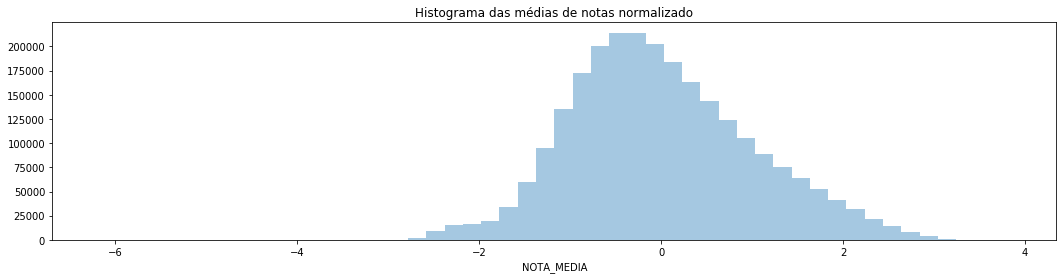

In [16]:
plt.figure(figsize=(18, 4))
sns.distplot(data["NOTA_MEDIA"], hist = True, kde = False).set_title("Histograma das médias de notas normalizado")

#### Sugestão: Checkar a validade de fatorizar e normalizar dados categoricos

### Feature selection

In [17]:
# Correlation Matrix

corr = data.corr()
#sns.heatmap(corr)
corr.style.background_gradient(cmap='coolwarm')

,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_LINGUA,Escolaridade_Pai,Escolaridade_Mae,Ocupacao_Pai,Ocupacao_Mae,Pessoas_na_casa,Renda,N_empregados_domesticos,N_banheiros,N_quartos,N_carros,N_motos,N_geladeiras,N_freezer,N_maquinas_lavar,N_secadoras,N_microondas,N_lava_loucas,Aspirdor_de_po,N_televisores,DVD,TV_assinatura,N_celulares,Telefone_fixo,N_computadores,Acesso_internet,NOTA_MEDIA
TP_SEXO,1.000000,-0.015308,-0.023077,0.012225,-0.001681,0.021844,-0.098449,0.074640,0.068547,0.068640,0.061294,-0.026170,0.091764,0.025851,0.057289,0.044354,0.068819,0.048888,0.033674,0.035863,0.073493,0.035542,0.060367,0.030404,0.056058,0.081488,0.013783,0.038558,0.046174,0.044878,0.104908,0.058303,0.070476
TP_ESTADO_CIVIL,-0.015308,1.000000,0.025010,-0.132607,0.295071,-0.128512,0.058248,-0.106982,-0.127752,-0.058667,-0.066138,-0.072062,-0.024249,-0.024014,-0.035856,-0.065499,-0.026606,-0.003036,-0.018903,-0.060103,-0.006438,-0.028503,-0.004561,-0.010713,-0.018767,-0.050683,-0.014999,-0.027251,-0.075735,-0.017293,-0.012797,-0.004458,-0.067702
TP_COR_RACA,-0.023077,0.025010,1.000000,-0.065106,0.051387,-0.107171,0.145419,-0.192501,-0.165527,-0.209534,-0.198101,0.095797,-0.257018,-0.102891,-0.198841,-0.128052,-0.246453,0.029561,-0.098126,-0.197711,-0.223104,-0.107218,-0.222068,-0.089319,-0.237615,-0.192793,-0.066379,-0.162893,-0.144344,-0.167465,-0.223762,-0.162621,-0.213082
TP_ST_CONCLUSAO,0.012225,-0.132607,-0.065106,1.000000,-0.567701,0.898342,-0.108632,0.153617,0.151100,0.106954,0.110096,0.081034,0.103350,0.082582,0.107894,0.103774,0.131843,0.011792,0.058700,0.119827,0.096406,0.073979,0.085622,0.047612,0.108922,0.115052,0.065051,0.101158,0.092901,0.057532,0.034350,0.031886,0.006501
TP_ANO_CONCLUIU,-0.001681,0.295071,0.051387,-0.567701,1.000000,-0.524232,0.122640,-0.206938,-0.227714,-0.115145,-0.121921,-0.143425,-0.060336,-0.067969,-0.088744,-0.124766,-0.102681,-0.015344,-0.046125,-0.147693,-0.060936,-0.079304,-0.055401,-0.035795,-0.077472,-0.099184,-0.045066,-0.080022,-0.144615,-0.037188,-0.003826,-0.030121,-0.042488
TP_ESCOLA,0.021844,-0.128512,-0.107171,0.898342,-0.524232,1.000000,-0.144371,0.232757,0.221876,0.203128,0.206814,0.053203,0.235249,0.167948,0.224094,0.156422,0.215934,-0.007009,0.103764,0.177548,0.147452,0.108438,0.145236,0.104480,0.183605,0.213751,0.097711,0.180770,0.144785,0.121921,0.132459,0.076429,0.119491
TP_LINGUA,-0.098449,0.058248,0.145419,-0.108632,0.122640,-0.144371,1.000000,-0.243120,-0.214771,-0.254360,-0.230927,0.050566,-0.269389,-0.115788,-0.215488,-0.129271,-0.213909,0.052358,-0.092991,-0.192800,-0.202094,-0.092939,-0.205029,-0.086472,-0.211987,-0.204079,-0.084117,-0.182572,-0.179082,-0.188059,-0.246831,-0.169951,-0.288748
Escolaridade_Pai,0.074640,-0.106982,-0.192501,0.153617,-0.206938,0.232757,-0.243120,1.000000,0.605108,0.603611,0.503319,-0.049381,0.492883,0.202661,0.391654,0.246721,0.368021,-0.048229,0.157749,0.280032,0.322141,0.158352,0.303123,0.145966,0.313077,0.331721,0.107975,0.306939,0.321176,0.265250,0.389926,0.267311,0.397829
Escolaridade_Mae,0.068547,-0.127752,-0.165527,0.151100,-0.227714,0.221876,-0.214771,0.605108,1.000000,0.479114,0.637484,-0.051604,0.454795,0.183622,0.357573,0.242642,0.344919,-0.009125,0.139164,0.241715,0.280429,0.135081,0.266586,0.121936,0.263087,0.287756,0.078504,0.267164,0.301542,0.221630,0.359040,0.256527,0.386537
Ocupacao_Pai,0.068640,-0.058667,-0.209534,0.106954,-0.115145,0.203128,-0.254360,0.603611,0.479114,1.000000,0.614273,-0.074118,0.553606,0.244671,0.443671,0.259564,0.421880,-0.075855,0.184185,0.309420,0.376633,0.183302,0.359838,0.162405,0.347583,0.385329,0.129147,0.341180,0.361232,0.300878,0.431238,0.314047,0.415661


In [18]:
corr['NOTA_MEDIA'].sort_values()

TP_LINGUA                 -0.288748
TP_COR_RACA               -0.213082
Pessoas_na_casa           -0.101629
TP_ESTADO_CIVIL           -0.067702
TP_ANO_CONCLUIU           -0.042488
N_motos                   -0.038631
TP_ST_CONCLUSAO            0.006501
TP_SEXO                    0.070476
DVD                        0.109211
TP_ESCOLA                  0.119491
N_lava_loucas              0.132803
N_secadoras                0.134121
N_geladeiras               0.142362
N_empregados_domesticos    0.198911
N_quartos                  0.233202
Telefone_fixo              0.245371
TV_assinatura              0.260310
N_maquinas_lavar           0.267474
Acesso_internet            0.268123
N_microondas               0.282770
N_freezer                  0.287178
N_celulares                0.293868
Aspirdor_de_po             0.297700
N_televisores              0.310119
N_carros                   0.354301
N_banheiros                0.384010
Escolaridade_Mae           0.386537
Escolaridade_Pai           0

In [19]:
# TP_ST_CONCLUSAO is highly correlated to TP_ESCOLA. So, we will remove one of them

data = data.drop("TP_ST_CONCLUSAO", 1)

#### Sugestão 6:Explorar melhor as técnicas para calcular feature importance, como Coeficiente de Gini, entropia, etc..

In [20]:
X_train, _, y_train, _ = train_test_split(data.drop("NOTA_MEDIA", 1), data["NOTA_MEDIA"], test_size=0.3)
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

Text(0.5, 1.0, 'Importância das variáveis')

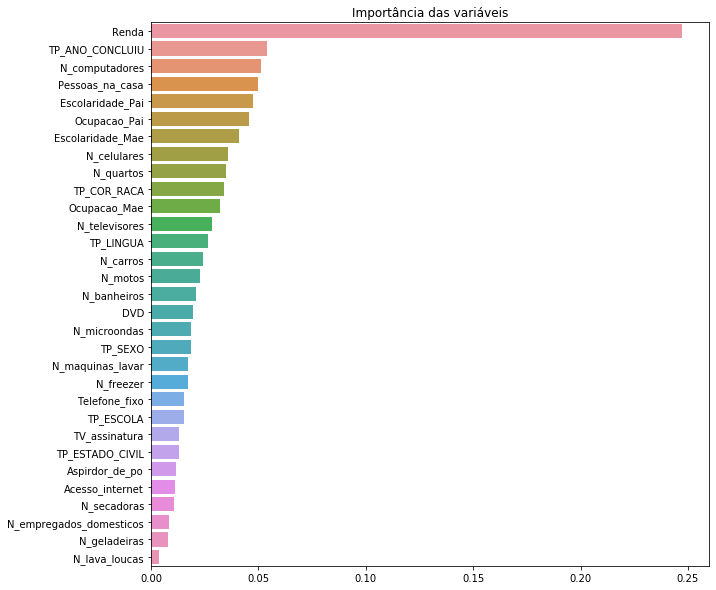

In [21]:
# Using Random Forest to calculate feature importance

model = RandomForestRegressor().fit(X_train, y_train)
importance = pd.Series(model.feature_importances_, index = data.drop(["NOTA_MEDIA"], 1).columns)
importance.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(10, 10))
sns.barplot(x = importance, y = importance.index).set_title("Importância das variáveis")

#### Sugestão 7: Quais critérios podemos usar para remover as variáveis?

#### Sugestão 8: Explorar outros modelos de machine learning com diferentes hiperparâmetros e comparar resultados. Encontrar explicações para as diferentes performaces dos modelos

#### Sugestão 9: Buscar a interpretabilidade do melhor modelo. Como cada parâmetro foi usado para o resultado final?

### Making predictions

In [23]:
_, X_test, _, y_test = train_test_split(data.drop("NOTA_MEDIA", 1), data["NOTA_MEDIA"], test_size=0.3)

In [24]:
# Training model with Q006

predictions = model.predict(X_test)

# Measuring score values

r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print("R2 Score: " + str(r2))
print("Mean Squared Error: " + str(mse))

R2 Score: 0.732471287933594
Mean Squared Error: 0.267174230754925


In [24]:
pd.DataFrame({"Predictions": (predictions)*std["NOTA_MEDIA"]+mean["NOTA_MEDIA"], 
              "Observed":y_test*std["NOTA_MEDIA"]+mean["NOTA_MEDIA"]}).reset_index().drop("index", 1).round(2)

,Predictions,Observed
0,544.80,475.92
1,507.62,514.50
2,598.23,735.46
3,542.70,482.92
4,546.41,358.36
...,...,...
1508389,502.14,462.68
1508390,503.66,519.48
1508391,525.67,555.90
1508392,511.74,466.58


In [33]:
# Training model with Q006 and Q024

train, test = train_test_split(data[["Q006", "Q024", "NOTA_MEDIA"]], test_size = 0.3)
model = RandomForestRegressor().fit(train.drop("NOTA_MEDIA", 1), train["NOTA_MEDIA"])
predictions = model.predict(test.drop("NOTA_MEDIA", 1))

# Measuring score values

r2 = r2_score(test["NOTA_MEDIA"], predictions)
mse = mean_squared_error(test["NOTA_MEDIA"], predictions)
print("R2 Score: " + str(r2))
print("Mean Squared Error: " + str(mse))

R2 Score: 0.2696030900027232
Mean Squared Error: 0.7308647579745471


In [34]:
pd.DataFrame({"Predictions": (predictions)*std["NOTA_MEDIA"]+mean["NOTA_MEDIA"], 
              "Observed":test["NOTA_MEDIA"]*std["NOTA_MEDIA"]+mean["NOTA_MEDIA"]}).reset_index().drop("index", 1).round(2)

,Predictions,Observed
0,616.84,626.80
1,475.91,506.80
2,490.68,523.82
3,475.91,477.32
4,475.91,478.72
...,...,...
950837,490.68,433.72
950838,465.91,378.58
950839,475.91,448.98
950840,575.45,578.18


In [30]:
# Training model

train, test = train_test_split(data, test_size = 0.3)
model = RandomForestRegressor().fit(train.drop("NOTA_MEDIA", 1), train["NOTA_MEDIA"])
predictions = model.predict(test.drop("NOTA_MEDIA", 1))

# Measuring score values

r2 = r2_score(test["NOTA_MEDIA"], predictions)
mse = mean_squared_error(test["NOTA_MEDIA"], predictions)
print("R2 Score: " + str(r2))
print("Mean Squared Error: " + str(mse))

R2 Score: 0.20960737939519536
Mean Squared Error: 0.7896905663707185


In [45]:
pd.DataFrame({"Predictions": (predictions)*std["NOTA_MEDIA"]+mean["NOTA_MEDIA"], 
              "Observed":test["NOTA_MEDIA"]*std["NOTA_MEDIA"]+mean["NOTA_MEDIA"]}).reset_index().drop("index", 1).round(2)

,Predictions,Observed
0,479.07,597.86
1,482.53,515.94
2,580.90,545.52
3,542.13,621.88
4,648.11,579.86
...,...,...
950837,524.20,516.32
950838,536.75,505.68
950839,454.03,573.74
950840,661.17,639.24


#### Sugestão 9: Explorar métricas para definir o melhor número de clusters e/ou explorar outras técnicas de aprendizado não supervisionado para definição dos clusters de forma a definir grupos com performances similares na prova

#### Sugestão 10: Identificar os padrões dos clusters. Como os clusters se relacionam em relação à media das notas? Qual o perfil dos alunos em clusters de menor média? Estão em que estados? Algum padrão socioeconomico claro que poderia identificar estes alunos?